In [ ]:
#@title LICENSE
MIT License

Copyright (c) 2025 SyntheticGANg

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

#Project Name: SyntheticGANg
Instructor: John Sipple

Team members:
* Sribalaji Senthilkumar
* Pranav Parthasarathy
* Sai Harsha Gangari

**Abstract:** Most of the current models perform well on medical datasets, but only for often occuring diseases and they fail to generalize well for the rare diseases. This is due to the disease being 'rare' itself and this leads to severe class imbalance in the dataset. This inturn leads the model to learn the
weights accurately. Additionally, augmenting image dataset with traditional image augmentation techniques like rotation, flippling, zooming, changing brightness is limited. To address this problem, we need to make use of 'GANs (Generative Adversarial Networks) to generate synthetic data as an additional augmenting technique to the image data augmentation problem.

**Problem:** Can we generate synthetic images of rare disease specimens so that the multi-class classification performance of a model is increased?

**Solution:** We can use of GANs (Generative Adversarial Networks) to generate synthetic data as one of the image data augmentation technique






# Installing libraries and Imports & GPU config (macOS)

In [76]:
#@title Install libraries for macOS to run tensorflow using available GPU (optional)
%pip install tensorflow-metal tensorflow-macos

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#@title Libraries installation
# We install all the necessary libraries along with 'medmnist' which is a medical
# image dataset for the project

%pip install pandas numpy matplotlib seaborn medmnist scikit-learn Pillow tensorflow opencv-python scikit-image tqdm

Note: you may need to restart the kernel to use updated packages.


In [77]:
#@title Set GPU memory growth (for macOS)
# Configure macOS to use MPS if possible. We will be running this
# in macbook

import tensorflow as tf
def setgpu():
  gpus = tf.config.list_physical_devices('GPU')
  print(gpus)
  for gpu in gpus:
      # tf.config.experimental.set_memory_growth(gpu, True)
      tf.config.set_visible_devices(gpus[0], 'GPU')
      print('gpus',gpu)

In [78]:
#@title Imports

import os
import sys
import datetime
from collections import Counter
from abc import ABC, abstractmethod

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from typing import Sequence,Tuple

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical

from medmnist import RetinaMNIST  # import RetinaMNIST class

In [79]:
#@title Python version
print(sys.version)

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]


# Dataset Download, Discription and Visualizations

*   Dataset: MedMNIST+
*   Category: RetinaMNIST
*   Image dimension: 64\*64\*3
*   Number of Classes: 5
*   Class Labels: 0,1,2,3,4
*   Train Sample Size: 1080
*   Test Sample Size: 400
*   Validation Sample Size: 120
*   Class distribution in train set: {0: 486, 4: 66, 3: 194, 2: 206, 1: 128}
*   Instance type: (PIL.Image.Image, nd.array)

In [238]:
#@title Set directories

# We need to set a base directory, so that all the project files can be accessed
# from the project directory and any additional data/images generated are stored
# with in this project directory scope.

#Ex: /Users/abc/GAN Project (Linux/MacOS)

# Base directory where the project files reside
base_dir = input('Enter the GAN Project directory path here! Please use absolute path')
print('Your project directory',base_dir)

# Date object. Used to identify the model weights while saving to a file
currentDate = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print('Current date and time:', currentDate)

# directory to store weights of cnn and gan model
weights_dir = f'{base_dir}/weights'
cnn_weights_dir = f'{weights_dir}/cnn'
gan_weights_dir = f'{weights_dir}/gan'

# directory to store gan generated images during training
image_dir_path = f'{base_dir}/generated_images_gL_{gen_learningRate}_dL{disc_learningRate}_{currentDate}'

# Directory to store gan generated images during testing
predicted_imgs_dir = f'{base_dir}/predicted_images/{currentDate}'


# directory to store images with best ssim scores
best_images_dir = f'{base_dir}/best_images/{currentDate}'

# Create directories if doesn't exist
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(cnn_weights_dir, exist_ok=True)
os.makedirs(gan_weights_dir, exist_ok=True)
# os.makedirs(images_dir, exist_ok=True)
os.makedirs(image_dir_path, exist_ok=True)
os.makedirs(predicted_imgs_dir, exist_ok=True)
os.makedirs(best_images_dir, exist_ok=True)

Enter the GAN Project directory path here! Please use absolute path/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project
Your project directory /Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project
Current date and time: 20250505-014939


In [239]:
#@title Download dataset

#Download the RetinaMNIST dataset from MedMNIST. The dataset is split into train,
#test and validation sets already. We just need to import them by specifying the
#split and download = True

train = RetinaMNIST(split='train',download=True,size=64)
test = RetinaMNIST(split='test',download=True,size=64)
val = RetinaMNIST(split='val',download=True,size=64)

*********        Dataset Description        *********
Dataset RetinaMNIST of size 64 (retinamnist_64)
    Number of datapoints: 1080
    Root location: /Users/saiharshagangari/.medmnist
    Split: train
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
    Number of samples: {'train': 1080, 'val': 120, 'test': 400}
    Description: The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.
    License: CC BY 4.0
*********        Plotting sample images        *********


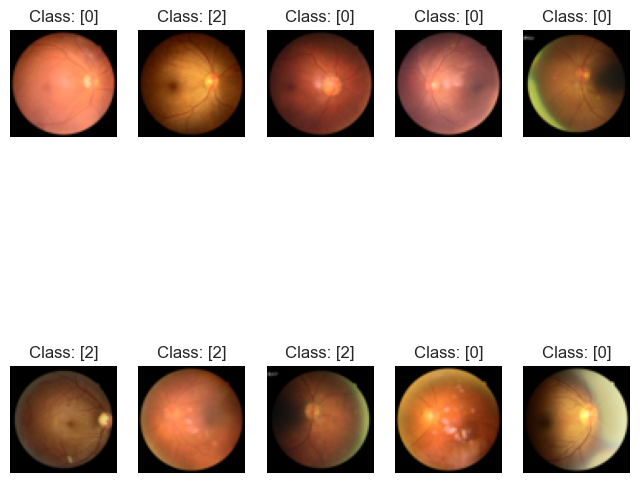

In [240]:
#@title Elementary Data Analysis

# We explore the train sample and visualize the data to get a better understanding
# of the dataset.
train_dataset = list(train)
test_dataset = list(test)
val_dataset = list(val)

def describe_dataset(train_data):
    """Prints the dataset description"""
    print(train_data)

def plot_images(train_subset:list)->None:
    """Prints 10 samples from the dataset provided

    Args:
    train_subset: take a chunk of instances of type (PIL.Image.Image, np.array([]))
    from train sample and plots the samples for visualization

    Returns: None

    """
    try:
        figure, axes = plt.subplots(2,5, figsize=(8,8))
        axes = axes.flatten()
        for id in range(0,10):
            img,lbl = train_subset[id]
            axes[id].imshow(img)
            axes[id].set_title(f'Class: {lbl}')
            axes[id].axis('off')
        plt.show()

    except Exception as e:
        print('Error occured while plotting images' ,e)

# Description of data is embedded by default in to the dataset
print('*********        Dataset Description        *********')
describe_dataset(train)

# Visualize sample instances of the data
print('*********        Plotting sample images        *********')
sample_subset = list(train)[570:580]
plot_images(sample_subset)


<h3>Inference:</h3>
<h5>
From the above train dataset description, we can infere that the dataset has 5 class labels pertianing to the retina specimens. Images in each instance is an RGB image of size 64\*64. 1080 samples are there in train set. It is evident that class 4 sample has 66 instances only; looking at the class distribution, which is extremely low to train a model to get a near perfect prediction results. Our particular interest is on class 4 samples i.e to upsample the class 4 samples for further augmentation of the data</h5>

***** Visualize Class 4 Samples *****


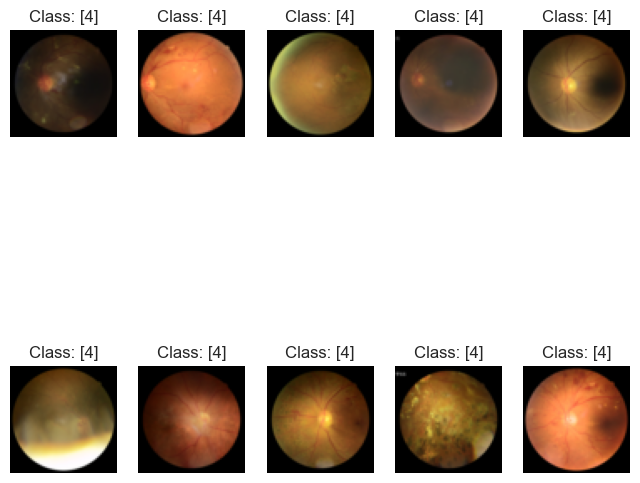

***** Shape of First Class 4 Sample *****
Shape of image: (64, 64), Label size: 1
Size of sample: 66


In [241]:
#@title EDA Part 2 - Visualizing Class 4 samples

class_4_dataset = [x for x in train_dataset if x[1] == 4]

print("***** Visualize Class 4 Samples *****")
plot_images(class_4_dataset[1:11])

print("***** Shape of First Class 4 Sample *****")
image, label = class_4_dataset[0]
print(f"Shape of image: {image.size}, Label size: {label.size}")

print(f"Size of sample: {len(class_4_dataset)}")


<h3> Inference: </h3>
<h5>
Class 4 samples are only 66 in count. We can see that there is much diversity in each instance of class 4 sample.</h5>

# Baseline CNN
> To prove that synthetic data augmentation can increase performance of a model, first we need to prove that a model performs poorly, comparatievely, on the original data. For this first we create a CNN model and train this model on our original data to establish baseline performance metrics such as F1-score, Accuracy, Recall and Precision.


> Our hypothesis is that if we add additional data to the original data by using synthetically generated images, the performance of the same model should increase. In this case, we are specifically interested to increase performance of the CNN model on ONLY class 4 samples as it can be assumed as rare disease in the problem's context




In [242]:
#@title Utility methods
# Utility methods for reusable functions

NUM_CLASSES = 5

def normalize_image(data)-> np.ndarray:
    """normalize the image data

    Args:
        data: Input image data to be normalized. Typically images in train, test,
        val datasets

    Returns:
        Normalized images data of type float32

    """
    return data.astype('float32')/255.0

def prepare_x_y_columns(data:list)-> tuple[np.ndarray, np.ndarray]:
    """Split the data in to input features and output labels

    Args:
        A list of tuples containing images and corresponding labels ranging from
        0 to 4.

    Returns:
        -Tuple of:
            -images as 64*64*3 numpy array
            -labels as one-hot encoded numpy array
    """
    X = [np.array(sample[0]) for sample in data]
    Y = [np.array(sample[1]) for sample in data]
    X = normalize_image(np.array(X,dtype='float32'))
    Y = np.squeeze(to_categorical(np.array(Y,dtype='int'),num_classes=NUM_CLASSES))
    return (X,Y)

def plot_loss_curve(history,listOfMetrics:list[str])-> None:
    """Plots a graph of loss curve of a model over epochs run

    Args:
        history: Keras training history of a model
        listOfMetrics: list of metrics to be plotted on the graph
    """
    for metric in listOfMetrics:
        if metric not in history.history:
            print(f"Metric '{metric}' not found in history.")
            continue
        else:
            plt.plot(history.history[metric], label=f'{metric}')

    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

def prepare_data_set(data:list)-> tf.data.Dataset:
    """Generates a dataset of type tf.data.Dataset from a list of tuples

    Args:
        data: List of tuples containing images and corresponding labels ranging
        from 0 to 4.

    Returns:
        ds: dataset of type tf.data.Dataset with shuffle, batch and prefetch
        methods applied
    """
    img,label = prepare_x_y_columns(data)

    ds = tf.data.Dataset.from_tensor_slices((img,label))
    ds = ds.shuffle(buffer_size=1080, seed=42).take(500)
    ds = ds.batch(128)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds

def augment_samples(data)-> tuple[list[np.ndarray], list[int]]:
    """ Augments image dataset to the original image dataset using conventional
    image data augmenting techniques like rotation, flipping.

    Args:
        data: Input of tuples of type (PIL.Image.Image,np.array([]))

    Returns:
        -images: list of augmented images
        -labels: list of augmented labels
    """
    augmented_data = []
    for sample in data:
        img = sample[0]
        label = sample[1][0]

        img = normalize_image(np.array(img,dtype='float32'))
        augmented_data.append((img,label))

        # Rotate the image by 90 degrees
        rotated_img = np.rot90(img)
        augmented_data.append((rotated_img,label))

        # Flip the image horizontally
        flipped_img = np.fliplr(img)
        augmented_data.append((flipped_img,label))

        # Flip the image vertically
        flipped_img_vertical = np.flipud(img)
        augmented_data.append((flipped_img_vertical,label))

        images = [sample[0] for sample in augmented_data]
        labels = [sample[1] for sample in augmented_data]


    return images,labels

def get_x_y_columns(data)-> tuple[np.ndarray, np.ndarray]:
    """Flattens a list of image-label batches into single arrays.

    Args:
        data: List of (images, labels) tuples (often batched from tf.data.Dataset).

    Returns:
        Tuple of:
            - X: NumPy array of all images.
            - Y: One-hot encoded NumPy array of all labels.
    """

    X = []
    Y = []
    for images, labels in data:
        for img, lbl in zip(images, labels):
            X.append(img)
            Y.append(lbl)

    X = np.array(X)
    Y = np.array(to_categorical(Y))
    return X, Y

In [243]:
#@title Base Algorithm
class BaseLearningAlgorithm(ABC):
    """Define a BaseLearningAlgorithm with conventional methods for a deep
    learning model
    """
    @abstractmethod
    def fit(self,
            xtrain:np.array,
            ytrain:np.array,
            xval:np.array,
            yval:np.array
            ) -> tf.keras.callbacks.History:
        """ An abstract method to define fit method.

        Args:
            xtrain: A numpy array of features in train sample
            ytrain: A numpy array of output labels in train sample
            xval: A numpy array of features in validation sample
            yval: A numpy array of output labels in validation sample

        Returns:
            A history object of type tf.keras.callbacks.History
        """

    @abstractmethod
    def predict_test(self,
                xtest:list,
                ytest:list
                )->list:

        """An abstract method to define fit method.

        Args:
            xtest: A numpy array of features in test sample
            ytest: A numpy array of output labels in test sample

        Returns:
            A list of predicted labels
        """

    @property
    @abstractmethod
    def name(self)->str:
        """Returns algorithm name"""

    @property
    def layers(self)-> Sequence[tf.keras.layers.Layer]:
        raise NotImplementedError()

    @property
    def input(self):
        """Returns model's input shape"""
        raise NotImplementedError()


In [244]:
#@title Defining Training and Evaluation methods
def train_eval(learning_algo: BaseLearningAlgorithm,
               ds_train: Tuple[np.ndarray,np.ndarray],
               ds_val: Tuple[np.ndarray,np.ndarray],
               ds_test: Tuple[np.ndarray,np.ndarray]
               )-> tf.keras.callbacks.History:
    """Trains and evaluates a learning algorithm of type BaseLearningAlgorithm.

    Args:
        learning_algo: An implementation of BaseLearningAlgorithm.
        ds_train: Tuple of training images and labels.
        ds_val: Tuple of validation images and labels.
        ds_test: Tuple of test images and true labels.

    Returns:
        Keras History object containing training history.
    """
    history = learning_algo.fit(ds_train[0],ds_train[1], ds_val[0],ds_val[1])

    y_test = ds_test[1]
    images = ds_test[0]

    y_pred =  learning_algo.predict_test(images)

    print('ypred',y_pred[:10])
    print('ytest',y_test[:10])

    print_report(learning_algo, y_test, y_pred)

    return history

def print_report(learning_algo:BaseLearningAlgorithm,y_test: np.ndarray,y_pred: np.ndarray) -> None:
    #print confusion matrix
    print("*******   Confusion Matrix *********")
    mat = confusion_matrix(y_test, y_pred)
    sns.set(rc = {'figure.figsize':(5,5)})
    sns.heatmap(
        mat.T,
        square=True,
        annot=True,
        fmt='d',
        cbar=False,
        xticklabels=['%d' %i for i in range(NUM_CLASSES)],
        yticklabels=['%d' %i for i in range(NUM_CLASSES)]
    )
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title(learning_algo.name)
    plt.show()

    print("*******   Classification Report: *********")
    print(classification_report(y_test, y_pred,
                              target_names=['%d' %i for i in range(NUM_CLASSES)]))

####Architecting CNN to establish baseline score using VGG19

Now we design a CNN architecture to establish a baseline performance metrics. For the CNN model we have tried using our own CNN layers along with FNN. Since the dataset is too low, the model quickly overfits and relaxing the constraints like learning rate, layer count and filter counts, the model tends to underfit. To bring to the expected results, we made use of pretained model to extract features. We have tried ResNet50 architecture but this too quickly overfits the model. We chose alternative VGG19 with only last few layers to be trainable coupled with FNN.

In [245]:
# CNN Architecture
from tensorflow.keras.applications import VGG19
from tensorflow.keras import metrics
from typing import Tuple, List


class CNN(BaseLearningAlgorithm):
    """CNN class using VGG19 feature extractor to classify the RetinaMNIST data """

    def __init__(self,epochs:int, learning_rate:float ) -> None:
        """Model initialization method

        Args:
            epochs: Number of epochs to train the model
            learningRate: Learning rate for the optimizer
        """
        self.model = None
        self.epochs = epochs
        self.loss = tf.losses.CategoricalCrossentropy()
        self.model = self.getmodel()
        self.learning_rate = learning_rate
        self.optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate,clipnorm=1.0)
        self.history = None

        # self.learning_rate_val_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,min_lr=5e-7)
        # self.learning_rate_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(self.learning_rate,decay_steps=70, end_learning_rate=2e-7,cycle=False)
        # self.learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(self.learning_rate, decay_rate=0.978, decay_steps=1000,staircase=False)


    @property
    def layers(self)->tf.keras.layers:
        """Returns the list layers of the model"""
        return self.model.layers

    def name(self)->str:
        """Returns name of the model"""
        return 'CNN hybrid model'


    def getmodel(self) -> tf.keras.models.Sequential:
        """Builds a CNN model with VGG19 model as base

        Returns:
            A compiled sequential CNN model with VGG19 model as base
        """
        vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(64, 64,3))

        #Freeze all the layers to prevent training
        for layer in vgg_model.layers:
            layer.trainable = False

        #Make the last 15 layers trainable
        for layer in vgg_model.layers[-15:]:
            layer.trainable = True

        #***********     Start of Feed forward Neural Network       **********
        hybrid_model = tf.keras.Sequential([
            vgg_model,
            tf.keras.layers.GlobalMaxPooling2D(),
            tf.keras.layers.Dense(110,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(2e-3)),
            tf.keras.layers.Dense(90,activation='relu'),
            tf.keras.layers.Dense(22,activation='relu'),
            tf.keras.layers.Dropout(0.1),

            #***********      Output layer       **********
            tf.keras.layers.Dense(5,activation='softmax')
        ])
        return hybrid_model

    def fit(self,
            xtrain,
            ytrain,
            xval,
            yval
            )->Sequence[tf.keras.callbacks.History]:
        """Trains the CNN model on training data

        Args:
            xtrain: A numpy array of features in train sample
            ytrain: A numpy array of output labels in train sample
            xval: A numpy array of features in validation sample
            yval: A numpy array of output labels in validation sample

        Returns:
            A keras training history object
        """

        print('Running fit method of CNN')

        earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)
        self.model.compile(optimizer=self.optimizer,loss=self.loss,metrics=[metrics.Precision(name='precision'),
                                                                            metrics.Recall(name='recall'),
                                                                            metrics.F1Score(name='f1_score'),
                                                                            metrics.AUC(name='auc',curve='ROC')
                                                                          ])
        # lRateSchedulerCallback = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
        self.history = self.model.fit(xtrain,ytrain, epochs=self.epochs,validation_data=(xval,yval),callbacks=[])
        return self.history

    #Predict method
    def predict_test(self, xtest) -> np.ndarray:
        """Runs inference on test data and returns predictions

        Args:
            xtest: A numpy array of features in test sample

        Returns:
            A numpy array of predicted labels
        """
        return np.argmax(self.model.predict(xtest),axis=1)

# Conventional Image Data Augmentation (Rotate, Flip)

As we can see that the train dataset has only 1080 instances, it is hard to train a model to establish a decent performance score. Since, we have tried with the original unaltered dataset, the model tries to overfit in almost all the cases. Hence, traditional data augmentation technique is used in this case to upsample the dataset.

We can also notice that there are only 66 samples of class 4 data. Eventhough with the upsampling techniques, we bring it to only 264 samples in total.

From each class, we picked 500 images randomly to train the model. Since we are short of images of type class 4, we oversampled the class 4 data by duplicating and then we picked 500 instances from this.

In [246]:
#@title Augmenting data

# Get the augmented data for each class category
augmented_data_class_0_images, augmented_data_class_0_labels = augment_samples([x for x in train_dataset if x[1] == 0])
augmented_data_class_1_images, augmented_data_class_1_labels = augment_samples([x for x in train_dataset if x[1] == 1])
augmented_data_class_2_images, augmented_data_class_2_labels = augment_samples([x for x in train_dataset if x[1] == 2])
augmented_data_class_3_images, augmented_data_class_3_labels = augment_samples([x for x in train_dataset if x[1] == 3])
augmented_data_class_4_images, augmented_data_class_4_labels = augment_samples([x for x in train_dataset if x[1] == 4])


# We need dataset of type tf.data.Dataset so that we can shuffle the dataset properly
# Convert train data to tensorflow dataset
ds_class_0 = tf.data.Dataset.from_tensor_slices((augmented_data_class_0_images,augmented_data_class_0_labels))
ds_class_1 = tf.data.Dataset.from_tensor_slices((augmented_data_class_1_images,augmented_data_class_1_labels))
ds_class_2 = tf.data.Dataset.from_tensor_slices((augmented_data_class_2_images,augmented_data_class_2_labels))
ds_class_3 = tf.data.Dataset.from_tensor_slices((augmented_data_class_3_images,augmented_data_class_3_labels))
ds_class_4 = tf.data.Dataset.from_tensor_slices((augmented_data_class_4_images,augmented_data_class_4_labels))


In [247]:
# We are concatenating class 4 samples with class 4 as this class is short of
# 234 samples nearly, where every other class is having more than 500 samples after
# augmentation.

ds_class_4 = ds_class_4.concatenate(ds_class_4)

# shuffle and pick 500 samples from each class
ds_class_0 = ds_class_0.shuffle(buffer_size=1000, seed=42).take(500)
ds_class_1 = ds_class_1.shuffle(buffer_size=1000, seed=42).take(500)
ds_class_2 = ds_class_2.shuffle(buffer_size=1000, seed=42).take(500)
ds_class_3 = ds_class_3.shuffle(buffer_size=1000, seed=42).take(500)
ds_class_4 = ds_class_4.shuffle(buffer_size=1000, seed=42).take(500)

# concatenate all the datasets together to create a single dataset
ds = (ds_class_0
.concatenate(ds_class_4)
.concatenate(ds_class_2)
.concatenate(ds_class_1)
.concatenate(ds_class_3))


# shuffle the dataset to ensure randomness and balance the classes per batch
ds = ds.shuffle(buffer_size=1080)
ds = ds.batch(128)
ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
train_data = list(ds.as_numpy_iterator())

# Prepare features and outputs from train dataset
X_train, Y_train = get_x_y_columns(train_data)

# Prepare features and outputs from validation dataset
val_dataset = list(val)
X_val,Y_val = prepare_x_y_columns(val_dataset)

# Prepare features and outputs from test dataset
test_dataset = list(test)
X_test,Y_test = prepare_x_y_columns(test_dataset)
Y_test = np.argmax(Y_test,axis=1)

2025-05-05 01:50:17.018162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [248]:
# Print shape of each dataset
print(f'Train samples = X_train: {X_train.shape}, Y_train: {Y_train.shape}')
print(f'Train samples = X_train: {X_val.shape}, Y_val: {Y_val.shape}')
print(f'Train samples = X_test: {X_test.shape}, Y_test: {Y_test.shape}')

Train samples = X_train: (2500, 64, 64, 3), Y_train: (2500, 5)
Train samples = X_train: (120, 64, 64, 3), Y_val: (120, 5)
Train samples = X_test: (400, 64, 64, 3), Y_test: (400,)


In [93]:
#@title Summarize the Baseline CNN Model

# Prepare an instance of CNN class with appropriate epochs and learning rate

use_pretained_cnn_weights = True #@param {type:"boolean"}
num_epochs_cnn = 19 #@param {type:"integer"}

if use_pretained_cnn_weights:
    cnn_model = CNN(epochs=num_epochs_cnn,learning_rate=3e-4)
    cnn_model.model.load_weights(f'{cnn_weights_dir}/baseline_cnn_weights.keras')
else:
    cnn_model = CNN(epochs=num_epochs_cnn,learning_rate=3e-4)
cnn_model.model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 2, 2, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_10         │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 110)            │        56,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 90)             │         9,990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 22)             │         2,002 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 5)              │           115 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,092,921 (76.65 MB)

 Trainable params: 19,832,761 (75.66 MB)

 Non-trainable params: 260,160 (1016.25 KB)

**Note**: If you just want to just see the confusion matrix by using pretained weights, check the box 'use_pretrained_cnn_weights' above.

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
gpus PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Running fit method of CNN
Epoch 1/19


2025-05-03 13:42:24.072759: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - auc: 0.5005 - f1_score: 0.1854 - loss: 1.9737 - precision: 0.4812 - recall: 0.0012 - val_auc: 0.6776 - val_f1_score: 0.1241 - val_loss: 1.7721 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/19
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - auc: 0.5614 - f1_score: 0.1450 - loss: 1.7881 - precision: 0.3628 - recall: 0.0102 - val_auc: 0.8073 - val_f1_score: 0.1803 - val_loss: 1.3945 - val_precision: 1.0000 - val_recall: 0.2583
Epoch 3/19
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - auc: 0.6576 - f1_score: 0.2269 - loss: 1.6278 - precision: 0.6881 - recall: 0.0877 - val_auc: 0.7652 - val_f1_score: 0.1969 - val_loss: 1.4628 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/19
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - auc: 0.6706 - f1_score: 0.2742 - loss: 1.5804 - precision: 0.7533 - recall: 0.0546 - val_auc: 0.7905 - val_f1_score: 0.3341 - val_loss: 1.3233 - val_precision: 1.0000 - val_recall: 0.2667
Epoch 5/19
79/79 ━━━━━━

2025-05-03 13:45:31.876337: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
ypred [0 1 0 1 0 0 1 1 0 2]
ytest [2 1 0 0 0 0 2 2 0 3]
*******   Confusion Matrix *********


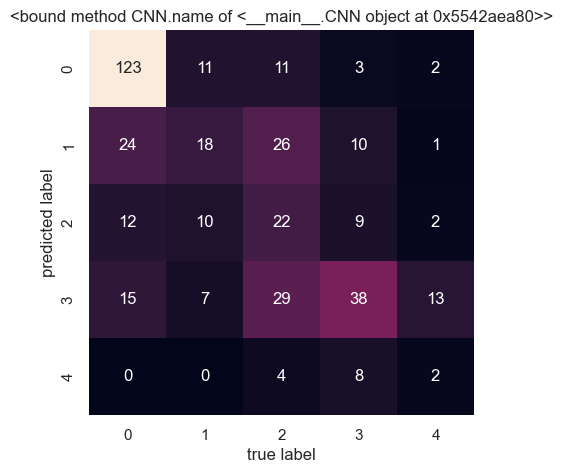

*******   Classification Report: *********
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       174
           1       0.23      0.39      0.29        46
           2       0.40      0.24      0.30        92
           3       0.37      0.56      0.45        68
           4       0.14      0.10      0.12        20

    accuracy                           0.51       400
   macro avg       0.39      0.40      0.38       400
weighted avg       0.55      0.51      0.51       400

CPU times: user 1min 10s, sys: 45.1 s, total: 1min 55s
Wall time: 3min 10s


In [ ]:
#@title Run the CNN model on conventional augmented dataset

# Dicatate code to use MPS on macOS
setgpu()

# If selected to use pretrained weights, then use the loaded model to predict
# image class

if use_pretained_cnn_weights:
    ypred = cnn_model.predict_test(X_test)
    print_report(cnn_model,Y_test,ypred)

# Train the model
else:
    %time history = train_eval(cnn_model,(X_train,Y_train),(X_val,Y_val),(X_test,Y_test))

<h3>Inference</h3>

> As we can see that, our **overall baseline performance metrics** are recorded as
*   Precision: 0.55
*   Recall: 0.51
*   F1-Score: 0.51
*   Accuracy: 0.51

> As we can see that, our **class 4 baseline performance metrics** are recorded as
*   Precision: 0.14
*   Recall: 0.10
*   F1-Score: 0.12





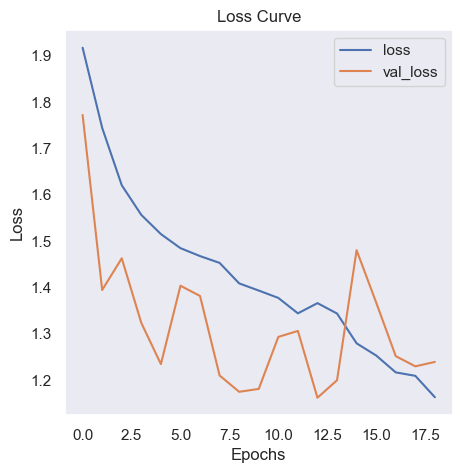

In [ ]:
#@title  Plot the loss curve
plot_loss_curve(history, ['loss', 'val_loss'])

In [ ]:
#@title Save model weights

# Save baseline CNN model weights
cnn_model.model.save(f'{cnn_weights_dir}/baseline_cnn_weights.keras')

# Start of GAN architecture

In [ ]:
#@title Utility methods part 2 (for GAN)

def prepare_data_set(data: List[Tuple[np.ndarray, Tuple[int]]]) -> Tuple[np.ndarray, np.ndarray]:
    """ Prepares dataset specific to train a GAN model.

    Args:
        data: List of (images, labels) tuples (often batched from tf.data.Dataset).

    Returns:
        X_train: List of images
        Y_train: List of labels
    """
    x_train=[]
    y_train=[]
    for sample in data:
        img = sample[0]
        label = sample[1][0]

        x_train.append(np.array(img,dtype='float32')/255.0)
        y_train.append(label)

    return np.array(x_train), np.array(y_train)


prepare_data_set(class_4_dataset)

x_train,y_train = prepare_data_set(class_4_dataset)

print(x_train.shape,y_train.shape)

(66, 64, 64, 3) (66,)


In [ ]:
#@title Augment class 4 samples only for GAN Training

x_gan_train, _ = augment_samples(class_4_dataset)

# Combine original class 4 samples with augmented samples
x_gan_train = np.concatenate((x_train, np.array(x_gan_train)), axis=0)

# Convert dataset into tf.data.Dataset for GAN training
ds = tf.data.Dataset.from_tensor_slices((x_gan_train))
ds = ds.batch(128)
ds = ds.shuffle(buffer_size=1080)
ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

<h3>Generator</h3>

For the generator architecture, we used ResNet style blocks. This is because model needs to grasp the features of images more preciesely so that our generator can learn better with low data. Residual connects helps the generator for a stabilized training

In [ ]:
#@title Architecting Generator

from tensorflow.keras.layers import (
    Input, Dense, Reshape,
    Conv2DTranspose, Conv2D,
    BatchNormalization, Activation,
    Add
)
from tensorflow.keras.models import Model

def up_res_block(x, filters, kernel_size=3):
    """Residual upsampling block for generator.

    Upsamples the input tensor and applies convolutional refinements
    with a residual skip connection.

    Args:
        x: Input tensor.
        filters: Number of filters for the Conv2D layers.
        kernel_size: Size of the convolution kernels.

    Returns:
        Output tensor after residual block.
    """

    shortcut = Conv2DTranspose(filters, 1, strides=2, padding='same', use_bias=False)(x)

    # Main path
    y = Conv2DTranspose(filters, kernel_size, strides=2, padding='same', use_bias=False)(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters, kernel_size, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)

    out = Add()([shortcut, y])
    return Activation('relu')(out)


def retina_generator(latent_dim: int = 128) -> Model:
    """Builds a generator model to synthesize 64×64 RGB images from latent space.

    Args:
        latent_dim: Dimension of the latent input vector.

    Returns:
        A Keras Model that maps latent vectors to 64×64×3 images.
    """
    inp = Input((latent_dim,))

    # 1) Project & reshape to 4×4×512
    x = Dense(4*4*512, use_bias=False)(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Reshape((4, 4, 512))(x)

    # 2) Four up‐sampling residual blocks: 8×8 → 16×16 → 32×32 → 64×64
    for f in [ 256, 128, 64, 32]:
        x = up_res_block(x, filters=f)

    # 3) Final RGB projection
    x = Conv2D(3, kernel_size=3, padding='same')(x)
    out = Activation('tanh')(x)

    return Model(inp, out, name='retina_generator')


In [ ]:
# Print summary of the generator model
generator = retina_generator()
generator.summary()

Model: "retina_generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 8192)      │  1,048,576 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8192)      │     32,768 │ dense_53[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 8192)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 4, 4, 512) │          0 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 8, 8, 256) │  1,179,648 │ reshape_1[0][0]   │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 256) │    589,824 │ activation_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 8, 8, 256) │    131,072 │ reshape_1[0][0]   │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 8, 8, 256) │          0 │ conv2d_transpose… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 8, 8, 256) │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_11 │ (None, 16, 16,    │    294,912 │ activation_12[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    147,456 │ activation_13[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_10 │ (None, 16, 16,    │     32,768 │ activation_12[0]

 Total params: 3,610,211 (13.77 MB)

 Trainable params: 3,591,907 (13.70 MB)

 Non-trainable params: 18,304 (71.50 KB)

In [ ]:
#@title Architecting Discriminator
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense, Reshape, Activation

def retina_discriminator():
    """Builds the discriminator model for 64×64 RGB images.

    The discriminator is a CNN that classifies whether input images are real or fake.
    It uses progressively deepening Conv2D layers with BatchNorm, LeakyReLU, and Dropout.

    Returns:
        A compiled Keras Sequential model.
    """
    model = tf.keras.Sequential()

    # Block 1
    ( model.add(Conv2D(96,kernel_size=3,padding='same',input_shape=(64,64,3))))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    # Block 2
    (model.add(Conv2D(54,kernel_size=4,kernel_regularizer=tf.keras.regularizers.l2(1e-4))))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))

    # Block 3
    (model.add(Conv2D(48,4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Block 4
    (model.add(Conv2D(18,4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.2))


    model.add(Flatten())
    model.add(Dense(50,activation='relu'))

    model.add(Dense(1)) # Output Layer without any activation function

    return model

In [ ]:
# Summarizing discriminator model
discriminator = retina_discriminator()
discriminator.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64, 64, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64, 64, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64, 64, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 61, 61, 54)     │        82,998 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 61, 61, 54)     │           216 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 61, 61, 54)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 61, 61, 54)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 58, 58, 48)     │        41,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 58, 58, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 58, 58, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 55, 55, 18)     │        13,842 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 55, 55, 18)     │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 55, 55, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 55, 55, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 54450)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 50)             │     2,722,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,864,513 (10.93 MB)

 Trainable params: 2,864,081 (10.93 MB)

 Non-trainable params: 432 (1.69 KB)

2025-05-03 15:32:19.544248: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
[[ 0.00069502]
 [ 0.00033389]
 [-0.00045859]]


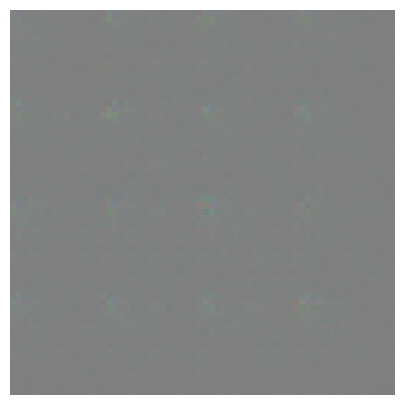

In [ ]:
#@title Print Sample image using generator

# Generate 3 synthetic images from latent vectors
img = generator.predict(np.random.randn(3, 128))

# Visualize the 3rd image (index 2), scaled back to [0, 1] range
visualized_image = (img[2] + 1) / 2.0
visualized_image = np.clip(visualized_image, 0.0, 1.0)

# Display the image
plt.imshow(np.array(visualized_image))
plt.axis('off')  # Optional for cleaner display

# Evaluate the generated batch using the discriminator
result = discriminator.predict(img)
print(result)


In [ ]:
#@title Defining Training loop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Learning rates
gen_learningRate = 2.8e-4
disc_learningRate = 3e-5


# Learning Rate schedulers
gen_learningRate_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    gen_learningRate,
    decay_steps=4800,
    end_learning_rate=9e-5,
    cycle=True
    )


disc_learningRate_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    disc_learningRate,
    decay_steps=5000,
    end_learning_rate=8e-7,
    cycle=True
    )

# gen_learningRate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    # gen_learningRate,
    # decay_steps=2500,
    # decay_rate=0.95,
    # staircase=False
    # )


# disc_learningRate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    # disc_learningRate,
    # decay_steps=1800,
    # decay_rate=0.95,
    # staircase=False
    # )

# Optimizers
gen_optimizer = Adam(learning_rate=gen_learningRate,beta_1=0.0,beta_2=0.999)
disc_optimizer = Adam(learning_rate=disc_learningRate,beta_1=0.0,beta_2=0.999)

# Loss Function
loss_function = BinaryCrossentropy(from_logits=False)

# Create directory to load or save weights of gan model
gan_weights_path = f'{base_dir}/weights/gan'
os.makedirs(gan_weights_path,exist_ok=True)

In [ ]:
#@title Define class for RetinaGAN

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


class RetinaGAN(Model):
    """RetinaGAN class to implement generator and discriminator with hinge loss
    and Structural Similarity Index loss
    """
    def __init__(self, latent_dim: int =128):
        """Constructor for RetinaGAN class.

        Args:
            latent_dim: Dimension of the latent input vector.
        """
        super().__init__()
        self.generator = retina_generator()
        self.discriminator = retina_discriminator()
        self.latent_dim = latent_dim
        self.current_epoch = tf.Variable(0, trainable=False, dtype=tf.int32)

        # Optinal : for perceptual loss
        # self.vgg = VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
        # self.vgg.trainable = False
        # self.perceptual_model = tf.keras.Model(self.vgg.input, self.vgg.get_layer("block3_conv3").output)

    def set_epoch(self, epoch:int ) -> None:
        """Sets the current training epoch (used for conditional logic)."""
        self.current_epoch.assign(epoch)


    def compile(self,
                gen_optimizer,
                disc_optimizer,
                loss_fn,
                useWeights: bool = False
                ) -> None:
        """Compiles RetinaGAN model with choosen optimizers and loss function.
        Optionally use existing weights to load both the generator and discriminator
        """
        super().compile()
        try:
          if useWeights:
            print('loading weights')
            self.generator.load_weights(f'{gan_weights_dir}/generator.weights.h5')
            self.discriminator.load_weights(f'{gan_weights_dir}/discriminator.weights.h5')
            print('weights loaded')
        except Exception as e:
          print('Error loading weights',e)

        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer

        # self.loss_fn = loss_fn

    def d_hinge_loss(self, real_logits, fake_logits) -> tf.Tensor:
        """Computes discriminator hinge loss"""
        real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_logits))
        fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_logits))
        return real_loss + fake_loss

    def g_hinge_loss(self,fake_logits) -> tf.Tensor:
        """Computes generator hinge loss"""
        return -tf.reduce_mean(fake_logits)

    @tf.function
    def train_step(self, real_images):
        """ Train generator and discriminator

        Args:
            real_images: Batch of real images.

        Returns:
            A dictionary of generator and discriminator losses.
        """

        batch_size = tf.shape(real_images)[0]
        real_images = (real_images - 0.5) * 2.0
        noise = tf.random.normal([batch_size, self.latent_dim])

        # Train discriminator
        for _ in range(4):
            with tf.GradientTape() as disc_tape:
                fake_images = self.generator(noise, training=True)
                real_logits = self.discriminator(real_images, training=True)
                fake_logits = self.discriminator(fake_images, training=True)

                d_loss = self.d_hinge_loss(real_logits, fake_logits)

            d_grads = disc_tape.gradient(d_loss, self.discriminator.trainable_weights)
            d_grads, _ = tf.clip_by_global_norm(d_grads, 1.0)
            self.disc_optimizer.apply_gradients(
                zip(d_grads, self.discriminator.trainable_weights)
            )

        # Train generator
        with tf.GradientTape() as gen_tape:
            fake_images = self.generator(noise, training=True)
            fake_logits = self.discriminator(fake_images, training=True)

            ssim_loss = 1.0 - tf.reduce_mean(tf.image.ssim(real_images, fake_images, max_val=2.0))

            g_loss = self.g_hinge_loss(fake_logits)  + 0.3*ssim_loss

        g_grads = gen_tape.gradient(g_loss, self.generator.trainable_weights)
        self.gen_optimizer.apply_gradients(
            zip(g_grads, self.generator.trainable_weights)
        )

        return {"d_loss": d_loss, "g_loss": g_loss}


In [ ]:
#@title Callbacks

from tensorflow.keras.callbacks import Callback

class RetinaGANMonitor(Callback):
    """Class to serve post epoch duties like saving images"""

    def __init__(self,num_img=20,latent_dim=128) -> None:
        """ RetinaGANMonitor constructor

        Args:
            num_img: Number of images to generate.
            latent_dim: Dimension of the latent input vector.
        """
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.epoch = 0

    def on_epoch_end(self,epoch,logs=None) -> None:
        """ Responsibilities to be taken on each epoch end

        Args:
            epoch: Current epoch number.
            logs: Dictionary of loss values.
        """
        self.epoch += 1
        random_latent_vectors = tf.random.normal(shape=(self.num_img,self.latent_dim))
        generated_images = self.model.generator.predict(random_latent_vectors)
        generated_images = (generated_images + 1) / 2.0


        # Save images to a directory
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f"{image_dir_path}/img-epoch-{epoch:03d}_{i}.png")

In [ ]:
#@title Create RetinaGAN instance

# Create RetinaGAN instance and compile
retinaGAN = RetinaGAN()
use_pretained_gan_weights = True #@param {type:"boolean"}
num_epochs = 300 #@param {type:"integer"}

setgpu()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
gpus PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
#@title Run the GAN Model

if use_pretained_gan_weights:
    retinaGAN.compile(gen_optimizer,disc_optimizer,loss_function,useWeights=use_pretained_gan_weights)
    print('Model weights loaded. You may now go to cell with title "Generate images by loading weights"')

else:
    retinaGAN.compile(gen_optimizer,disc_optimizer,loss_function)
    history = retinaGAN.fit(ds,epochs=num_epochs,callbacks=[RetinaGANMonitor()])

Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - d_loss: 0.0742 - g_loss: 3.9216
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - d_loss: 0.0017 - g_loss: 4.1388
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - d_loss: 0.0149 - g_loss: 4.7468
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - d_loss: 0.0014 - g_loss: 3.8568
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - d_loss: 0.0000e+00 - g_loss: 3.9012
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - d_loss: 0.0000e+00 - g_loss: 3.8783
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - d_loss: 4.4538e-04 - g_loss: 3.4241
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - d_loss: 5.0522e-04 - g_loss: 3.7276
Epoch 9/300
1

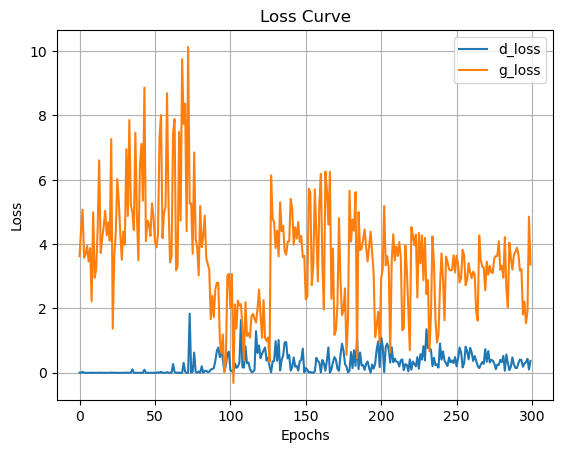

In [ ]:
#@title Plot the GAN loss curve

# Plot the generator and discriminator loss curve
metrics_list = ["d_loss", "g_loss"]
plot_loss_curve(history, metrics_list)

<h3> Inference </h3>

> We can see the loss curves of both generator and discriminator. It is expected of the discriminator that it overpowers the generator in inital epochs (till ~75 epochs in this case). Then after, the loss curve of generator has been oscillating significantly and then nearly stabilized after 250 epochs. Although, discriminator loss was oscillating between 0 to 2, it remained with in loss of 0.5 most of the time.

In [ ]:
#@title Save GAN model weights

# Save the generator and discriminator weights
retinaGAN.generator.save_weights(f'{gan_weights_dir}/generator.weights.h5')
retinaGAN.discriminator.save_weights(f'{gan_weights_dir}/discriminator.weights.h5')

loading weights
weights loaded


2025-05-02 21:55:12.860931: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


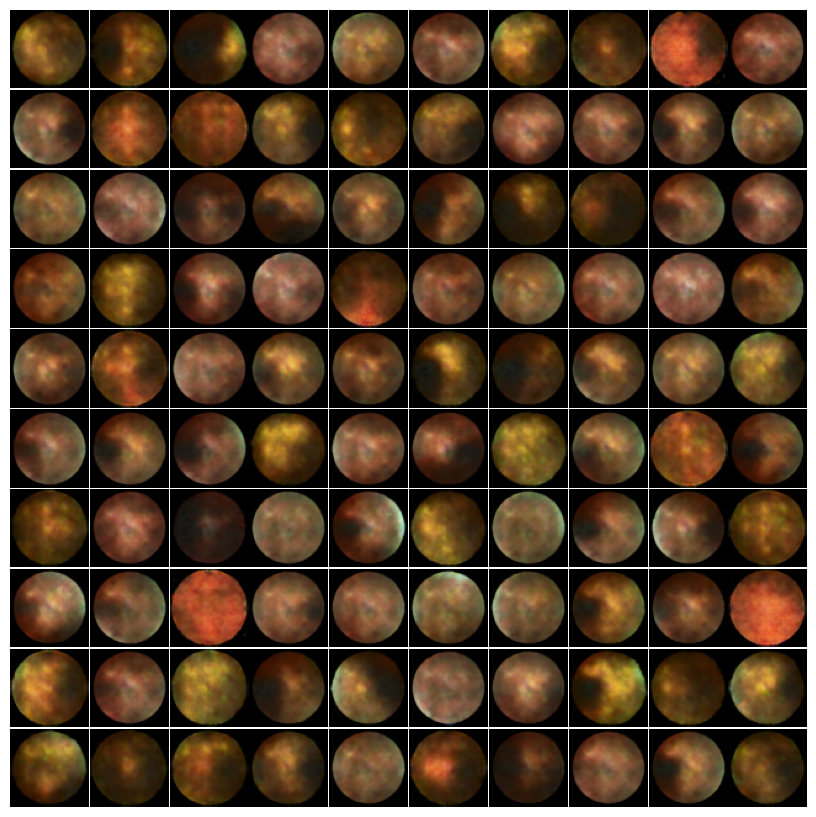

In [ ]:
#@title Generate images by loading weights

# Snippet to generate 500 images using the generator

NUM_IMAGES = 500
LATENT_DIM = 128


latent_vectors = np.random.normal(size=(NUM_IMAGES,LATENT_DIM))
generated_images = retinaGAN.generator.predict(latent_vectors)
generated_images = (generated_images + 1) / 2.0


# Save generated images in the dir
for i in range(NUM_IMAGES):
    img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
    img.save(f"{predicted_imgs_dir}/img_{i}.png")


# Visualize 100 images generated by the generator model
rows, cols = 10, 10
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))

for ax, img in zip(axes.flatten(), generated_images):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout(pad=0.1)
plt.show()

<h3> Comments </h3>

> The above plot prints 100 samples of class 4 retina images generated by our trained retina generator model. The generator was quick to adapt to the shape, colors and edges of the retina. However, the model struggled to learn the key details like blood vessels well and images are blurry.

In [ ]:
#@title Calculate SSIM (Structural Similarity Index) score to retain top K images
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim


IMAGE_SIZE = (64,64)
TOP_K_IMAGES = 300

# Load and process all original class-4 samples
real_imgs = []
for img, _label in class_4_dataset:
    arr = np.array(img)
    if arr.ndim == 3:
        arr = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    arr = cv2.resize(arr, IMAGE_SIZE)
    arr = arr.astype(np.float32) / 255.0
    real_imgs.append(arr)

real_imgs = np.stack(real_imgs, axis=0)
print('real image shape:', real_imgs[0].shape)

# Computer SSIM score between generated and real images
ssim_scores = []
for filename in os.listdir(predicted_imgs_dir):
    filepath = os.path.join(predicted_imgs_dir, filename)
    fake_img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    fake_img = cv2.resize(fake_img, (64, 64))
    fake_img = fake_img.astype(np.float32) / 255.0

    similarities = [
        ssim(fake_img, real_img, data_range=1.0)
        for real_img in real_imgs
    ]
    ssim_scores.append((filename, max(similarities)))


ssim_scores.sort(key=lambda x: x[1], reverse=True)
top_300 = ssim_scores[:TOP_K_IMAGES]

print("Top 300 generated images by SSIM:")
for filename, score in top_300:
    print(f"{filename}: SSIM={score:.4f}")



real image shape: (64, 64)
Top 150 generated images by SSIM:
img_207.png: SSIM=0.8038
img_346.png: SSIM=0.7897
img_221.png: SSIM=0.7760
img_51.png: SSIM=0.7751
img_491.png: SSIM=0.7720
img_157.png: SSIM=0.7710
img_413.png: SSIM=0.7659
img_98.png: SSIM=0.7654
img_241.png: SSIM=0.7620
img_386.png: SSIM=0.7612
img_112.png: SSIM=0.7584
img_83.png: SSIM=0.7559
img_459.png: SSIM=0.7530
img_96.png: SSIM=0.7513
img_188.png: SSIM=0.7490
img_113.png: SSIM=0.7469
img_439.png: SSIM=0.7465
img_50.png: SSIM=0.7462
img_214.png: SSIM=0.7457
img_401.png: SSIM=0.7457
img_277.png: SSIM=0.7445
img_275.png: SSIM=0.7432
img_417.png: SSIM=0.7431
img_77.png: SSIM=0.7418
img_95.png: SSIM=0.7417
img_424.png: SSIM=0.7395
img_255.png: SSIM=0.7386
img_446.png: SSIM=0.7383
img_135.png: SSIM=0.7376
img_322.png: SSIM=0.7369
img_369.png: SSIM=0.7348
img_186.png: SSIM=0.7344
img_245.png: SSIM=0.7341
img_445.png: SSIM=0.7335
img_233.png: SSIM=0.7330
img_291.png: SSIM=0.7330
img_471.png: SSIM=0.7323
img_324.png: SSIM=0.7

The SSIM( Structural Similarity Index Measure) score of generated images was calculated to be of 0.8 when compared to the real images. Where, if achieved 1, this is the perfect score for a Structural Similarity Index Measure score

In [ ]:
#@title Calculate FID Score of the generated images

from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import (
    InceptionV3,
    preprocess_input,
)

TARGET_IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32

# Load real images and reshape to (299,299,3)
real_imgs = []
for pil_img, _ in class_4_dataset:
    arr = np.array(pil_img)
    if arr.ndim == 2:
        arr = np.stack([arr] * 3, axis=-1)
    arr = cv2.resize(arr, TARGET_IMAGE_SIZE, cv2.INTER_AREA)
    real_imgs.append(arr.astype(np.float32))

real_imgs = preprocess_input(np.stack(real_imgs, axis=0))
print("real batch shape:", real_imgs.shape)


# Load fake images and reshape to (299,299,3)
synth_imgs = []
for filename in os.listdir(predicted_imgs_dir):
    filepath = os.path.join(predicted_imgs_dir, filename)
    img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    if img is None:
        continue
    if img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, TARGET_IMAGE_SIZE, cv2.INTER_AREA)
    synth_imgs.append(img.astype(np.float32))
synth_imgs = preprocess_input(np.stack(synth_imgs, axis=0))
print("synth batch:", synth_imgs.shape)


# Prepare Inception block
inception = InceptionV3(
    include_top=False, pooling="avg", input_shape=(299, 299, 3)
)

def get_activations(imgs):
    return inception.predict(imgs, batch_size=BATCH_SIZE, verbose=0)

acts_real = get_activations(real_imgs)
acts_fake = get_activations(synth_imgs)


# Calculate mean and covariance
mu_real = acts_real.mean(axis=0)
sigma_real = np.cov(acts_real, rowvar=False)

mu_fake = acts_fake.mean(axis=0)
sigma_fake = np.cov(acts_fake, rowvar=False)

# Calculate FID score
diff = mu_real - mu_fake
covmean = sqrtm(sigma_real.dot(sigma_fake))

# Check if result is real
if np.iscomplexobj(covmean):
    covmean = covmean.real

fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2.0 * covmean)
print(f"FID = {fid:.4f}")

real batch: (66, 299, 299, 3)
synth batch: (500, 299, 299, 3)


2025-05-02 21:57:54.083710: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


FID = 88.8837


The  Fréchet Inception Distance (FID) score achieved in around 88. This too low to call the generated images to be 'realistic'. For an acceptable generated image, FID score should be around 20-40. This means  our model still has scope to  learn features well. But balancing the equilibrium between the discriminator and generator is quite difficult.

In [ ]:
#@title Save best images to a folder
import shutil

# Save the images
for filename,_ in top_300:
    shutil.copy(os.path.join(predicted_imgs_dir, filename), best_images_dir)

/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/
/Users/saiharshagangari/GWU/Spring 2025/NNDL/GAN Project/best_generatedimages/20250502-205122


# Retrain the CNN model using the synthetic images

Now, we train the CNN model once again to see if there is any improvement in the performance using 'synthetic images' in this section

In [46]:
#@title Prepare train dataset by augmenting the synthetic dataset
from PIL import Image

TARGET_LABEL = 4

img_list =[]

for filename in os.listdir(best_images_dir):
  img_path = os.path.join(best_images_dir,filename)
  img = Image.open(img_path)
  img = img.convert('RGB')
  img = img.resize(IMAGE_SIZE)

  img_list.append((img,np.array([TARGET_LABEL])))

In [47]:
#@title Prepare augmented dataset

# Normalize generated class 4 images and assign labels
normalized_image_list = [(normalize_image(np.array(x[0])),(x[1])) for x in img_list]

# Split into separate image and label arrays
imgs, labels = zip(*normalized_image_list)
imgs = np.array(imgs)
labels = np.array(np.squeeze(labels),dtype=np.int32)

# Convert the original class 4 images into type int32
augmented_data_class_4_labels = np.array(augmented_data_class_4_labels,dtype=np.int32)

In [48]:
# Combine class 0,1,2,3 instances
ds = (ds_class_0
      .concatenate(ds_class_1)
      .concatenate(ds_class_2)
      .concatenate(ds_class_3)
)

# Add augmented class 4 data (original + generated images)
ds_class_4 = (tf.data.Dataset
              .from_tensor_slices((augmented_data_class_4_images,
                                   augmented_data_class_4_labels))
                )

# Merge real and synthetic class 4 samples
images_class4 = np.concatenate((augmented_data_class_4_images,imgs)).astype(np.float32)
labels_class4 = np.concatenate((augmented_data_class_4_labels,labels)).astype(np.int32)

# Take only 236 class 4 samples, as we ensure only 500 samples are present per
# class
NUM_CLASS4_SAMPLES = 236
augmented_ds_class_4 = (tf.data.Dataset
               .from_tensor_slices((images_class4,labels_class4))
               .shuffle(buffer_size=2000)
               .take(NUM_CLASS4_SAMPLES)
)

# Merge original and augmented class 4 datasets
ds_class_4 = ds_class_4.concatenate(augmented_ds_class_4)

# Combine all classes including augmented class 4 dataset
ds = ds.concatenate(ds_class_4)

# Shuffle, Batch and Prefetch
ds = ds.shuffle(buffer_size=2000)
ds = ds.batch(128)
ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Convert to list
dataset = list(ds)

# Extract features and labels
X_aug_train, Y_aug_train = get_x_y_columns(dataset)

2025-05-04 23:33:07.376197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [249]:
#@title Run CNN - Augmented data

num_epochs_aug_cnn = 19 #@param {type:"integer"}
use_pretained_aug_cnn_weights = True #@param {type:"boolean"}

if use_pretained_aug_cnn_weights:
  augment_cnn_model = CNN(epochs=num_epochs_aug_cnn,learning_rate=3e-4)
  augment_cnn_model.model.load_weights(f'{cnn_weights_dir}/improved_cnn_model_perf_weights.keras')
else:
    augment_cnn_model = CNN(epochs=num_epochs_aug_cnn,learning_rate=3e-4)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
gpus PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2025-05-05 01:50:26.056851: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
*******   Confusion Matrix *********


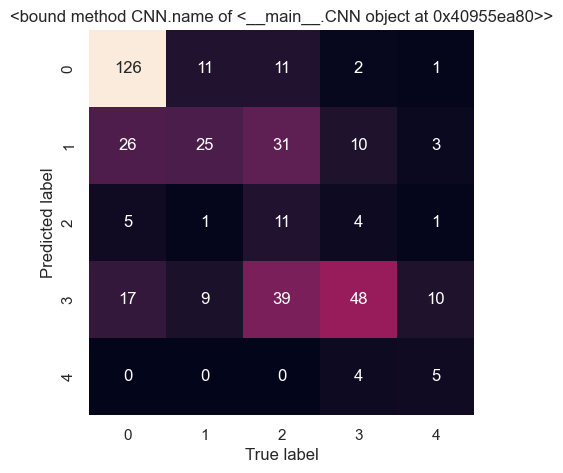

*******   Classification Report: *********
              precision    recall  f1-score   support

           0       0.83      0.72      0.78       174
           1       0.26      0.54      0.35        46
           2       0.50      0.12      0.19        92
           3       0.39      0.71      0.50        68
           4       0.56      0.25      0.34        20

    accuracy                           0.54       400
   macro avg       0.51      0.47      0.43       400
weighted avg       0.60      0.54      0.53       400



In [250]:
# Run the CNN model with augmented dataset
# Run the CNN model with augmented dataset
setgpu()

if use_pretained_aug_cnn_weights:
    res = augment_cnn_model.predict_test(X_test)
    print_report(augment_cnn_model,Y_test,res)
else:
    %time history = train_eval(augment_cnn_model,(X_aug_train,Y_aug_train),(X_val,Y_val),(X_test,Y_test))

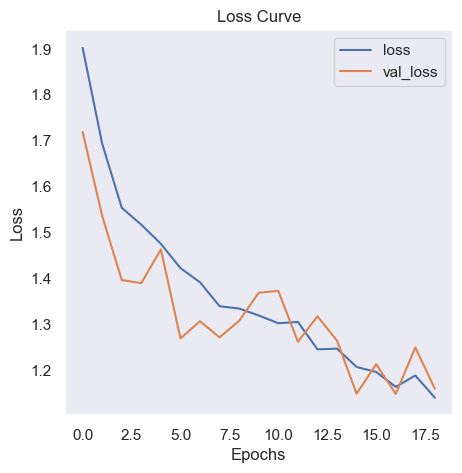

In [ ]:
#Plot loss curve
plot_loss_curve(history,['loss','val_loss'])

In [ ]:
#@title Save model weights
augment_cnn_model.model.save(f'{cnn_weights_dir}/improved_cnn_model_perf_weights.keras')